# The Late Adjusted Parallel Sampler (LAPS)

If you are able to run many chains in parallel (e.g. around as many chains as the number of independent samples you would like  to take), and you have a problem with a differentiable density, [LAPS]() is a much faster alternative to sequential methods such as HMC.

## Parallelism in MCMC

The initial state $x_i$ of an MCMC chain is not typically distributed according to the target distribution $p(x)$, and a "burn in" or "equilibration" phase of the chain is required. Running many MCMC chains in parallel doesn't decrease the wallclock time of this phase.

Once chains are equilibrated, parallelism is helpful: if you have $100$ chains with state $\{x_i^n\}_{n=1}^{100}$, you can  evolve all of them in parallel until each generates a new effectively independent sample. This is roughly 100 times faster (in wallclock time) than collecting 100 samples from a single chain.

## The core idea of LAPS

It has been observed that among gradient-based MCMC methods, unadjusted kernels (i.e. kernels without Metropolis-Hastings) converge to the target distribution faster than adjusted ones. The idea of LAPS is simply to use an unadjusted kernel until this point, and then switch to an adjusted kernel to remove remaining bias.

The details involve determining when this switching point should take place, and tuning the hyperparameters of the kernels.

In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

num_cores = jax.local_device_count()
print(num_cores)

import blackjax
from blackjax.adaptation.laps import laps as run_laps

# import os, sys
# sys.path.append('../../../blackjax/')



def laps(logdensity_fn, ndims, 
         sample_init, rng_key, 
         num_steps1, num_steps2, 
         num_chains, mesh):

    info, grads_per_step, _acc_prob, final_state = run_laps(    
        logdensity_fn=logdensity_fn, 
        sample_init= sample_init,
        ndims= ndims, 
        num_steps1=num_steps1, 
        num_steps2=num_steps2, 
        num_chains=num_chains, 
        mesh=mesh, 
        rng_key= rng_key, 
        early_stop= False,
        diagonal_preconditioning= True, 
        steps_per_sample=15,
        r_end=0.01,
        diagnostics= False,
        superchain_size= 1
        )

    return final_state.position


1


# Example

Use LAPS as follows:

In [4]:

ndims = 2

def logdensity_fn(x):
        mu2 = 0.03 * (x[0] ** 2 - 100)
        return -0.5 * (jnp.square(x[0] / 10.0) + jnp.square(x[1] - mu2))


rng_key_sampling, rng_key_init = jax.random.split(jax.random.key(42))

# Function that takes a random seed and produces a vector of parameters. Each chain will be initialized by calling this function with a different random seed.
sample_init = lambda key: jax.random.normal(key, shape= ndims) 

### Run sampling:

In [7]:

num_chains = 256
num_steps1, num_steps2 = 100, 100

mesh = jax.sharding.Mesh(jax.devices()[:1], 'chains')

print('Number of devices: ', len(jax.devices()))

info, grads_per_step, _acc_prob, samples = run_laps(
    logdensity_fn=logdensity_fn,
    sample_init= sample_init,
    ndims= ndims, 
    num_steps1=num_steps1, 
    num_steps2=num_steps2, 
    num_chains=num_chains, 
    mesh=mesh, 
    rng_key= jax.random.key(0), 
    early_stop= False,
    diagonal_preconditioning= True, 
    steps_per_sample=15,
    r_end=0.01,
    diagnostics= False,
    superchain_size= 1
)

Number of devices:  1


### Visualize the posterior samples:

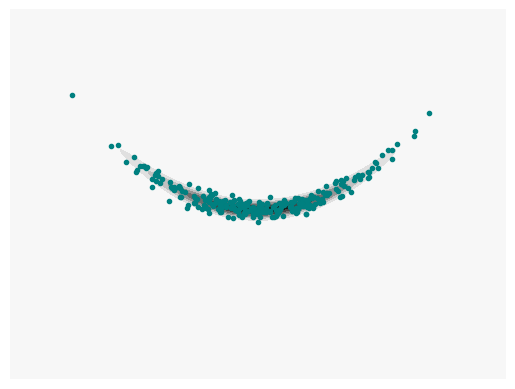

In [8]:
import matplotlib.pyplot as plt

x1 = jnp.linspace(-35, 35, 500)
x2 = jnp.linspace(-35, 35, 500)
X1, X2= jnp.meshgrid(x1, x2)
X = jnp.stack((X1, X2), axis=-1)
Z = jnp.exp(jax.vmap(jax.vmap(logdensity_fn))(X))

plt.plot(samples.position[:, 0], samples.position[:, 1], '.', color = 'teal')
plt.contourf(X1, X2, Z, cmap = 'Greys')
plt.axis('off')
plt.show()


# What is the speed-up?

The above example runs 256 chains *in parallel*, each for 200 steps. So, apart from parallelism overhead, this should take about the same as running 1 chain for 200 steps.

To see how many independent samples we get, we can use the fact that we know (or rather, have an accurate estimate of) the true second moments of the 2D Banana, so we can report the difference between the true second moments and the estimate (we normalize by the second moment standard deviations):


In [11]:
ground_truth_second_moment_mean=jnp.array([100.0, 19.0])
ground_truth_second_moment_standard_deviation=jnp.sqrt(jnp.array([20000.0, 4600.898]))

estimated_second_moment_mean=jnp.mean(samples.position**2, axis=0)

error = (estimated_second_moment_mean - ground_truth_second_moment_mean) / ground_truth_second_moment_standard_deviation

error

Array([-0.10905137, -0.10199353], dtype=float64)

This is the error one would obtain from 100 exact independent samples, so we can say that LAPS has given us an effective sample size of 100. To get the same from a sequential method would take a chain at least 10 times longer, so LAPS gives a wallclock speed-up here of at least an order of magnitude (and often quite a bit more - see the paper).